# Baselines: working with Codex

from secrets_ import API_KEY


In [1]:
import openai

ModuleNotFoundError: No module named 'openai'

In [1]:
# Create a script that generates baselines from our demos using codex
import requests
import random 
import time
import json
import numpy as np
import pandas as pd
import re 
import os
from tqdm import tqdm
import seaborn as sns
from itertools import product
# from codex_api_key import API_KEY


ModuleNotFoundError: No module named 'openai'

In [3]:
openai.apikey = API_KEY
openai.ChatCompletion()

<ChatCompletion at 0x7fc9298a8cb0> JSON: {}

In [4]:
input_text = "let f x1 = "
assert_ = "assert ((f 0 = -2) && (f 1 = 2) && (f 2 = (2 + 2 + 2)) && ((f (-1)) =  -6))"



out = get_codex_completion(input_text,assert_,max_tokens=20,temperature=1)
print("OUTPUT:")
print(input_text + out['choices'][0]['message']['content'] + assert_)

NameError: name 'get_codex_completion' is not defined

In [5]:
def get_codex_edit(text,n=7,temperature=0.99): 
    model = "code-davinci-edit-001"
    instruction = "edit the function to pass the assert statement. Do not edit the assert statement"
    openai.api_key = API_KEY
    response = openai.Edit.create(model=model,input=text,instruction=instruction,temperature=temperature)
    if 'choices' in response.keys(): 
        return response['choices'][0]['text'], response
    return None, response 

In [6]:
import subprocess 
def test_input(text,assert_,use_temp_file='temp.txt'):
    test_text = text + '\n' + assert_
    with open(use_temp_file, 'w') as file:
        file.write(test_text)
    prc = subprocess.run(['ocaml','temp.txt'],stdout=subprocess.DEVNULL,stderr=subprocess.DEVNULL )
    return prc.returncode == 0
test_input(input_text,assert_)

False

In [7]:
input_text = \
"""let f x1 = (2 * ((x1 * 2) - 1)) in
assert ((f 0 = -2) && (f 1 = 2) && (f 2 = (6)) && ((f (-1)) = (-6)))"""

values = get_codex_edit(input_text,n=7,temperature=0.2)
print(values)

('let f x1 = (2 * ((x1 * 2) - 2)) in\nassert ((f 0 = -2) && (f 1 = 2) && (f 2 = (6)) && ((f (-1)) = (-6)))\n', <OpenAIObject edit at 0x7fc9298ab590> JSON: {
  "object": "edit",
  "created": 1693711265,
  "choices": [
    {
      "text": "let f x1 = (2 * ((x1 * 2) - 2)) in\nassert ((f 0 = -2) && (f 1 = 2) && (f 2 = (6)) && ((f (-1)) = (-6)))\n",
      "index": 0
    }
  ],
  "usage": {
    "prompt_tokens": 79,
    "completion_tokens": 47,
    "total_tokens": 126
  }
})


openai.Edit.create()

In [8]:
def get_completion(prompt,assrt,max_tokens=20,temperature=1.0):
    if assrt: 
        function = f'{prompt}\n    ?\n{assrt}'
    else: 
        function=prompt
    messages = [{'role':'user','content':function},
                {'role':'user','content':'Replace the question mark in the above ocaml function with ocaml code that passes the assert.' }]

    jsonobj = {
        "model": "gpt-3.5-turbo", 
        # "prefix": "(* ocaml code *)",
        'messages':messages,
        "temperature": temperature,
        "max_tokens": max_tokens
    }
    resp = openai.ChatCompletion.create(
        **jsonobj
    )
    insertion = resp['choices'][0]['message']['content'] if 'choices' in resp.keys() else None
    if insertion:
        return insertion, resp
    return (None, resp)

def get_question_edit(prompt,assert_=None, max_tokens=20,temperature=1.0):
    if assert_: 
        function = f'{prompt}\n    ?\n{assert_}'
    else: 
        function=prompt

    instruction= 'Replace the question mark in the above ocaml function with ocaml code that passes the assert.' 
    model = "code-davinci-edit-001"

    resp = openai.Edit.create(model=model,
                                  input=function,
                                  instruction=instruction,
                                  temperature=temperature)
    insertion = resp['choices'][0]['text'] if 'choices' in resp.keys() else None
    if insertion:
        return insertion, resp
    return (None, resp)



# Test 2 var tests on codex 

In [41]:
counts = 0 
corrects = 0 
for _,file_n in (bar := tqdm(list(product(range(20),os.scandir('data/blank_2var_tests'))))): 
    if re.match(r'.*\.ml',file_n.name): 
        with open(file_n.path,'r') as file: 
            test = file.read()
            test = test.replace('!', 'not') 
        res, json = get_completion(test,None,max_tokens=100)
        if res: 
            assert_stmt = test.split('?')[1]
            func_body = res.split('in')[0]
            # print(func_body + assert_stmt)
            if test_input(func_body,assert_stmt): 
                corrects +=1
            counts +=1 
            # time.sleep(20)

    chat_success_rate = corrects/counts if counts != 0 else 0.0 
    bar.set_description(f'success_rate = {chat_success_rate:1.2f}')
    bar.bar_format = '{l_bar}{bar}{r_bar}' + f'file={file_n.name}'

print(f'Chat completion format score = {chat_success_rate}')

success_rate = 0.08: 100%|██████████| 300/300 [09:59<00:00,  2.00s/it]file=6.ml              

Chat completion format score = 0.07857142857142857


In [ ]:
time.sleep(60)

In [9]:
counts = 0 
corrects = 0 
min_time_per_cycle = 3.001
begin_time = time.time()

for _,file_n in (bar := tqdm(list(product(range(20),os.scandir('data/blank_2var_tests'))))): 
    if re.match(r'.*\.ml',file_n.name): 
        # the other (non-depricated endpoint) handles rate limits. This one does not. 
        # Therefore we need to handle rate limits ourselves. 
        # handle rate limit stuff (albeit jankily)
        end_time = time.time()
        if (elapsed_time := end_time - begin_time) < min_time_per_cycle:
            # enforce min of two seconds per cycle to avoid rate limit 
            time.sleep(min_time_per_cycle - elapsed_time)
        begin_time = time.time()
        # process request 
        with open(file_n.path,'r') as file: 
            test = file.read()
            test = test.replace('!', 'not') 
        res, json = get_question_edit(test,None,max_tokens=100)
        if res: 
            assert_stmt = test.split('?')[1]
            func_body = res.split('in')[0]
            # print(func_body + assert_stmt)
            if test_input(func_body,assert_stmt): 
                corrects +=1
            counts +=1 




    edit_success_rate = corrects/counts if counts != 0 else 0.0 
    bar.set_description(f'success_rate = {edit_success_rate:1.2f}')
    bar.bar_format = '{l_bar}{bar}{r_bar}' + f'file={file_n.name}'

print(f'Chat completion format score = {edit_success_rate}')

success_rate = 0.17:   2%|▏         | 7/300 [00:19<14:36,  2.99s/it]file=one_var_3.ml

# Do other tests... 

In [39]:
input_text.find('assert')
print(input_text[:input_text.find('assert')])

let f x1 = (2 * ((x1 * 2) - 1)) in



In [10]:
REPLACE_DICT = {
        r'\*':(lambda :'/'),
        r'/' :(lambda : '*'),
        r'\W\-?\d':(lambda :' ' + str(random.randint(-7,7))),
        r'\-' :(lambda :'+'),
        r'\+' : (lambda :'-'),
        r'!=': (lambda : '='),
    
} 
instr = "let even x = (((x / 2) * -2) != x) in List.filter even x"
muts = []
for key in REPLACE_DICT.keys(): 
        iters = re.finditer(key,instr)
        iters =  list(iters)
        muts  += list(zip(iters, (key for _ in iters)))
random.shuffle(muts)

def replace(mut,str_):
    replace_with = REPLACE_DICT[mut[1]]()
    print(mut,replace_with, mut[0].start(),mut[0].end())
    return str_[:mut[0].start()] + replace_with + str_[mut[0].end()-1:] 

replace(muts[0],instr)

(<re.Match object; span=(24, 27), match=' -2'>, '\\W\\-?\\d')  -1 24 27


'let even x = (((x / 2) * -12) != x) in List.filter even x'

In [11]:
REPLACE_DICT = {
        r'\*':(lambda :'/'),
        r'\W\-?\d':(lambda :' ' + str(random.randint(-7,7))),
        r'\-' :(lambda :'+'),
        r'\+' : (lambda :'-')
} 

def replace(mut,str_):
    replace_with = REPLACE_DICT[mut[1]]()
    return str_[:mut[0].start()] + replace_with + str_[mut[0].end():] 

def create_mutant(in_text, num_edits = 1,look_for_assert=False): 
    assert_start = in_text.find('assert') if look_for_assert else len(in_text)
    in_text,assert_ = in_text[:assert_start],in_text[assert_start:]
    # find all edit points 
    edit_list = []
    for key in REPLACE_DICT.keys(): 
            iters = re.finditer(key,instr)
            iters =  list(iters)
            edit_list  += list(zip(iters, (key for _ in iters)))
            
    if num_edits > len(edit_list): 
        print(f"WARNING: TOO MANY EDITS REQUESTED (wanted {num_edits}; max sites = {len(edit_list)}")
        num_edits=len(edit_list)
    random.shuffle(edit_list)
    
    for i in range(num_edits):
        edit_list = []
        for key in REPLACE_DICT.keys(): 
                iters = re.finditer(key,in_text)
                iters = list(iters)
                edit_list  += list(zip(iters, (key for _ in iters)))
        random.shuffle(edit_list)
        edit = edit_list[0]
        in_text = replace(edit,in_text)
    return in_text + assert_
print(input_text)
print(create_mutant(input_text))

let f x1 = (2 * ((x1 * 2) - 1)) in
assert ((f 0 = -2) && (f 1 = 2) && (f 2 = (6)) && ((f (-1)) = (-6)))
let f x1 = (2 * ((x1 * 2) - 1)) in
assert ((f 0 = 1) && (f 1 = 2) && (f 2 = (6)) && ((f (-1)) = (-6)))


In [12]:

def get_codex_insert(prefix,suffix,temperature=1): 
    header = {"Authorization": f"Bearer {API_KEY}"}
    jsonobj = {
        "model": "code-davinci-002", 
        "prompt": prefix, 
        "suffix":suffix,
        "max_tokens": 256,
        "temperature": temperature,
    }
        
    r = requests.post( headers=header,
        url ="https://api.openai.com/v1/completions", 
        json=jsonobj)
    response = r.json()
    if 'choices' in response.keys(): 
        return prefix + response['choices'][0]['message']['content'] + suffix, response
    return None, response 

In [13]:
# some handling functions for making strings from prompts objects 
VAR_N_LIST = ['x', 'y','z','w','t']

def de_id_prototype(prompt): 
    proto = prompt['prototype']
    funcs = re.findall(r'let (\w+) (?:\w+ )+=',proto)
    func_dict = {func:f'f{i+1}' for i,func in enumerate(funcs)}
    for func,repl in func_dict.items():
        proto = re.sub(func,repl,proto)

    return proto, func_dict

def get_prototype(prompt,de_id:bool=False): 
    return de_id_prototype(prompt)[0] if de_id else prompt['prototype']

def make_func_block(prompt,inc_types:bool=True,inc_comment:bool=False,de_id:bool=False): 
    res = ''
    if inc_comment: 
        res += f"(* {prompt['description']} *)\n"
    types = prompt['types'].split(' -> ')
    # handle de-identified functions
    if de_id: 
        res += 'let f ' 
    else: 
        res += f'let {prompt["name"]} ' 
    for i, type_ in enumerate(types[:-1]): 
        type_ = type_.strip()
        if inc_types: 
            res  += f'({VAR_N_LIST[i]} : {type_}) '
        else: 
            res += f'{VAR_N_LIST[i]} '
    if inc_types: 
        res += f': {types[-1].strip()} ' 
    res += ' = '
    return res 

def make_assert(prompt,no_info_name:bool=False,de_id:bool=False): 
    if de_id: 
        return prompt['assert']
    name = prompt['name']
    return prompt['assert'].replace('f ',f'{name} ')

def make_func_prototype(prompt,inc_types:bool=True,inc_comment:bool=False,de_id:bool=False,func_body=None): 
    block = make_func_block(prompt,inc_types=inc_types,inc_comment=inc_comment,de_id=de_id)
    if func_body is None: 
        func_body = prompt['prototype']
    return f"{block} \n  {func_body} \nin \n"

In [14]:
# get prompts, solutions and values: 
with open('data/prompts.json') as file: 
    prompts_obj = json.load(file)
    prompts_obj = [ obj for obj in prompts_obj if 'name' in obj.keys()]


In [37]:
len(prompts_obj)

9

In [40]:
def make_tests(prompts_obj,n_tests_per = 5,
        log_str="", edit_mode:bool=False, 
        de_id:bool=False,inc_comment:bool=False,
        inc_type:bool=False, n_edits=2
): 
    resps = [] 
    n_failures = 0 
    log_str += f"~~~~~~~~~~~ BEGIN TEST: {len(prompts_obj)} prompts {n_tests_per} each,"\
            + f" edit:{edit_mode},{n_edits} d_id:{de_id} com:{inc_comment} typ:{inc_type}~~~~~~~~~~~~\n"
    # base loop 
    while len(resps) < len(prompts_obj)*n_tests_per:
        promptnum = len(resps)%len(prompts_obj)
        prompt = prompts_obj[promptnum]
        log_str  += f'\n~~~New test on prompt {promptnum}: {prompt["name"]}\n'
        # then get codex's input
        if edit_mode: 
            # if we want to make an, edit, use mutation logic 
            mut = create_mutant(get_prototype(prompt,de_id=de_id),num_edits=n_edits,look_for_assert=False)
            mut = make_func_prototype(prompt,de_id=de_id,inc_types=inc_type, inc_comment=inc_comment,func_body=mut)
            mut = mut + make_assert(prompt,de_id=de_id)
            # verify edit fails, otherwise retry from start 
            if test_input(mut, ''): 
                print('mutant did not fail test; re-generating...') 
                continue
            # get result from codex 
            out_code,resp = get_codex_edit(mut,n=3,temperature=0.2)
        else: 
            # codex fills in our block for us, no mutating logic
            prefix = make_func_block(prompt,inc_types=inc_type,inc_comment=inc_comment,de_id=de_id)
            suffix = "\nin \n" + make_assert(prompt)
            out_code, resp = get_codex_insert(prefix,suffix,temperature=0.7)
        # now check that result is correct, otherwise handle error
        if out_code :
            
            test_res = test_input(out_code, '')
            log_str += str(out_code) + f'\noutput_correctness: {test_res}\n'
            resps.append(test_res)
        else :
            if("Rate limit reached" in  resp['error']['message']):
                time.sleep(60)
                continue
            log_str +="invalid response \n" + str(values) + " \n"
            n_failures +=1
    return resps, n_failures,log_str

In [41]:
def make_name_from_args(edit_mode=True,de_id=True,
                        inc_comment=False,inc_type=True):
    name = "edit" if edit_mode else "insert" 
    if de_id: name += "_deid"
    name += '_w_desc' if inc_comment else '_no_desc'
    if inc_type:
        name += '_w_type'
    return name
    

# Test codex in a number of different ways:

Do a few experiments to test how codex performs 

When testing wtih a function stated, the following is prepended to the prompt`(* f(x) = 2((2x)-1) *)`

1. Test codex doing just an edit on mutated code 
1. Test codex doing an edit on mutated code that has a comment stating the function
1. Test codex building the function from scratch using insert mode 
1. Test codex building the function from scratch using insert mode and a comment stating the function

In [44]:
# create a dict containing accuracies and deviations from each run 
codex_stats = {}
num_gens_per_prompt = 10

In [45]:
# run all the tests we originally had in lower cells. 
log_str = ""
#  iterate through cartesian product of each set of values 

for edit_mode,de_id,inc_comment,inc_type in tqdm(product([False,True],repeat=4),total=2**4): 
    # make name 
    name = make_name_from_args(edit_mode,de_id,inc_comment,inc_type)
    resps,n_failures,log_str = make_tests(prompts_obj,log_str=log_str,n_tests_per=num_gens_per_prompt,
                                          edit_mode=edit_mode,de_id=de_id,
                                          inc_comment=inc_comment,inc_type=inc_type)

    print(name)
    print(f'avg: {sum(resps)/len(resps)}; stdev: {np.std(resps)}; Num failures: {n_failures}')
    codex_stats[name]  = {
        "acc": sum(resps)/len(resps),
        "std":np.std(resps),
        'failures': n_failures,
    }
with open('data/log_file.txt','w') as file: 
    file.write(log_str)


  0%|                                                    | 0/16 [00:00<?, ?it/s]File "./temp.txt", line 3, characters 26-31:
3 |   | h :: t -> (h + 2) :: (add_2 t) 
                              ^^^^^
Error: Unbound value add_2
Hint: If this is a recursive definition,
you should add the 'rec' keyword on line 1
File "./temp.txt", line 4, characters 23-32:
4 | 	| h :: t -> (h+2) :: (add_2_rec t)
                           ^^^^^^^^^
Error: Unbound value add_2_rec
Hint: If this is a recursive definition,
you should add the 'rec' keyword on line 2
File "./temp.txt", line 2, characters 0-6:
2 | filter (fun x -> x != 0) x
    ^^^^^^
Error: Unbound value filter
File "./temp.txt", line 10, characters 0-2:
10 | in 
     ^^
Error: Syntax error
Exception: Assert_failure ("./temp.txt", 16, 0).
Exception: Assert_failure ("./temp.txt", 11, 0).
Exception: Assert_failure ("./temp.txt", 7, 0).
File "./temp.txt", line 8, characters 10-23:
8 | assert (((nonzero_add_2 [1 ; 2; 0; 6; -2]) = [3; 4; 8; 0]) && 

insert_no_desc
avg: 0.5222222222222223; stdev: 0.4995059287330894; Num failures: 25


File "./temp.txt", line 9, characters 0-2:
9 | in 
    ^^
Error: Syntax error
Exception: Assert_failure ("./temp.txt", 9, 0).
Exception: Assert_failure ("./temp.txt", 11, 0).
File "./temp.txt", line 7, characters 10-19:
7 | assert (((even_elts [1 ; 2; 3; 6; -1]) = [2;6;]) && ((even_elts []) = []) && ((even_elts [-2; -1; -2]) = [-2; -2]))
              ^^^^^^^^^
Error: Unbound value even_elts
Hint: If this is a recursive definition,
you should add the 'rec' keyword on line 1
File "./temp.txt", line 7, characters 34-38:
7 | else let result = result@[res] in loop tl result
                                      ^^^^
Error: This function has type int list -> int list -> int list
       It is applied to too many arguments; maybe you forgot a `;'.
File "./temp.txt", line 4, characters 15-18:
4 | | x::xs -> 1 + len xs
                   ^^^
Error: Unbound value len
Hint: If this is a recursive definition,
you should add the 'rec' keyword on line 1
File "./temp.txt", line 7, characters 10-13:
7

insert_no_desc_w_type
avg: 0.4222222222222222; stdev: 0.4939135726865081; Num failures: 0


File "./temp.txt", line 8, characters 10-15:
8 | assert (((add_2 [1 ; 2; 3; 6; -1]) = [3 ; 4; 5; 8; 1]) && ((add_2 []) = []) && ((add_2 [-2; -2; -2]) = [0; 0; 0]))
              ^^^^^
Error: Unbound value add_2
Hint: If this is a recursive definition,
you should add the 'rec' keyword on line 2
File "./temp.txt", line 9, characters 10-26:
9 | assert (((nonzero_elements [1 ; 2; 0; 6; -1]) = [1 ; 2; 6; -1]) && ((nonzero_elements []) = []) && ((nonzero_elements [0; 0; 0]) = []) )
              ^^^^^^^^^^^^^^^^
Error: Unbound value nonzero_elements
Hint: If this is a recursive definition,
you should add the 'rec' keyword on line 2
Exception: Assert_failure ("./temp.txt", 12, 0).
File "./temp.txt", line 6, characters 39-45:
6 |     | h :: t -> if h != 0 then h+2 :: (helper t) else (helper t)
                                           ^^^^^^
Error: Unbound value helper
Hint: If this is a recursive definition,
you should add the 'rec' keyword on line 3
File "./temp.txt", line 6, characters 18-

insert_w_desc
avg: 0.6444444444444445; stdev: 0.4786813161897337; Num failures: 0


File "./temp.txt", line 6, characters 15-35:
6 | | h::t -> h+2::(helper t (count+1))
                   ^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int list
       This is not a function; it cannot be applied.
File "./temp.txt", line 5, characters 17-20:
5 | | h :: t -> 1 + (len t)
                     ^^^
Error: Unbound value len
Hint: If this is a recursive definition,
you should add the 'rec' keyword on line 2
File "./temp.txt", line 6, characters 10-21:
6 | | h::t -> product_rec t (acc * h)
              ^^^^^^^^^^^
Error: This function has type int list -> int -> int
       It is applied to too many arguments; maybe you forgot a `;'.
File "./temp.txt", line 10, characters 10-19:
10 | assert (((even_elts [1 ; 2; 3; 6; -1]) = [2;6;]) && ((even_elts []) = []) && ((even_elts [-2; -1; -2]) = [-2; -2]))
               ^^^^^^^^^
Error: Unbound value even_elts
Hint: If this is a recursive definition,
you should add the 'rec' keyword on line 2
File "./temp.txt", line 13, character

insert_w_desc_w_type
avg: 0.5777777777777777; stdev: 0.4939135726865081; Num failures: 0


File "./temp.txt", line 6, characters 0-2:
6 | in 
    ^^
Error: Syntax error
File "./temp.txt", line 4, characters 10-15:
4 | assert (((add_2 [1 ; 2; 3; 6; -1]) = [3 ; 4; 5; 8; 1]) && ((add_2 []) = []) && ((add_2 [-2; -2; -2]) = [0; 0; 0]))
              ^^^^^
Error: Unbound value add_2
File "./temp.txt", line 10, characters 0-2:
10 | in 
     ^^
Error: Syntax error
File "./temp.txt", line 3, characters 10-19:
3 | assert (((even_elts [1 ; 2; 3; 6; -1]) = [2;6;]) && ((even_elts []) = []) && ((even_elts [-2; -1; -2]) = [-2; -2]))
              ^^^^^^^^^
Error: Unbound value even_elts
File "./temp.txt", line 4, characters 0-2:
4 | in 
    ^^
Error: Syntax error
File "./temp.txt", line 13, characters 10-13:
13 | assert (((len [1 ; 2; 0; 6; -2]) = 5 ) && ((len []) = 0) && ((len [0; -2; -3]) = 3 ))
               ^^^
Error: Unbound value len
File "./temp.txt", line 8, characters 0-2:
8 | in 
    ^^
Error: Syntax error
File "./temp.txt", line 1, characters 11-18:
1 | let f x  = product x
   

insert_deid_no_desc
avg: 0.16666666666666666; stdev: 0.372677996249965; Num failures: 0


File "./temp.txt", line 3, characters 10-15:
3 | assert (((add_1 [1 ; 2; 3; 6; -1]) = [2 ; 3; 4; 7; 0]) && ((add_1 []) = [] ) && ((add_1 [-1; -1; -1]) = [0;0;0]) )
              ^^^^^
Error: Unbound value add_1
File "./temp.txt", line 4, characters 10-15:
4 | assert (((add_2 [1 ; 2; 3; 6; -1]) = [3 ; 4; 5; 8; 1]) && ((add_2 []) = []) && ((add_2 [-2; -2; -2]) = [0; 0; 0]))
              ^^^^^
Error: Unbound value add_2
File "./temp.txt", line 18, characters 0-2:
18 | in 
     ^^
Error: Syntax error
File "./temp.txt", line 7, characters 0-115:
7 | assert (((even_elts [1 ; 2; 3; 6; -1]) = [2;6;]) && ((even_elts []) = []) && ((even_elts [-2; -1; -2]) = [-2; -2]))
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Error: This expression has type unit but an expression was expected of type
         int list
File "./temp.txt", line 14, characters 0-2:
14 | in 
     ^^
Error: Syntax error
File "./temp.txt", line 1, characters

insert_deid_no_desc_w_type
avg: 0.03333333333333333; stdev: 0.17950549357115012; Num failures: 0


File "./temp.txt", line 4, characters 0-2:
4 | in 
    ^^
Error: Syntax error
File "./temp.txt", line 4, characters 0-2:
4 | in 
    ^^
Error: Syntax error
File "./temp.txt", line 12, characters 10-26:
12 | assert (((nonzero_elements [1 ; 2; 0; 6; -1]) = [1 ; 2; 6; -1]) && ((nonzero_elements []) = []) && ((nonzero_elements [0; 0; 0]) = []) )
               ^^^^^^^^^^^^^^^^
Error: Unbound value nonzero_elements
Hint: If this is a recursive definition,
you should add the 'rec' keyword on line 9
File "./temp.txt", line 4, characters 0-2:
4 | in 
    ^^
Error: Syntax error
File "./temp.txt", line 8, characters 0-2:
8 | in 
    ^^
Error: Syntax error
File "./temp.txt", line 2, characters 4-5:
2 | let f x  = 
        ^
Warning 26: unused variable f.
File "./temp.txt", line 4, characters 0-2:
4 | in 
    ^^
Error: Syntax error
File "./temp.txt", line 7, characters 0-2:
7 | in 
    ^^
Error: Syntax error
File "./temp.txt", line 4, characters 0-2:
4 | in 
    ^^
Error: Syntax error
File "./temp

insert_deid_w_desc
avg: 0.3333333333333333; stdev: 0.47140452079103173; Num failures: 0


File "./temp.txt", line 8, characters 0-114:
8 | assert (((add_1 [1 ; 2; 3; 6; -1]) = [2 ; 3; 4; 7; 0]) && ((add_1 []) = [] ) && ((add_1 [-1; -1; -1]) = [0;0;0]) )
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Error: This expression has type unit but an expression was expected of type
         int list
File "./temp.txt", line 8, characters 0-114:
8 | assert (((add_2 [1 ; 2; 3; 6; -1]) = [3 ; 4; 5; 8; 1]) && ((add_2 []) = []) && ((add_2 [-2; -2; -2]) = [0; 0; 0]))
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Error: This expression has type unit but an expression was expected of type
         int list
File "./temp.txt", line 16, characters 0-2:
16 | in 
     ^^
Error: Syntax error
File "./temp.txt", line 11, characters 0-2:
11 | in 
     ^^
Error: Syntax error
File "./temp.txt", line 17, characters 0-2:
17 | in 
     ^^
Error: Syntax error
Fil

false
true
false


File "./temp.txt", line 20, characters 45-51:
20 |     | h::t -> if h = 0 then helper t ys else helper t (h+2::ys)
                                                  ^^^^^^
Error: This function has type int list -> int list -> int list
       It is applied to too many arguments; maybe you forgot a `;'.
File "./temp.txt", line 26, characters 4-6:
26 |     in 
         ^^
Error: Syntax error
File "./temp.txt", line 8, characters 0-98:
8 | assert (((product [1 ; 2; -1; 6; -2]) = 24 ) && ((product []) = 1) && ((product [1; -2; -3]) = 6))
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Error: This expression has type unit but an expression was expected of type
         int
File "./temp.txt", line 19, characters 0-2:
19 | in 
     ^^
Error: Syntax error
File "./temp.txt", line 2, characters 35-38:
2 | let f (x : int list) : int list  = map (fun (x : int) -> x + 2) x ;;
                                       ^^^
Error: Unbound value map
Hi

insert_deid_w_desc_w_type
avg: 0.044444444444444446; stdev: 0.20608041101101562; Num failures: 0
mutant did not fail test; re-generating...
mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).


mutant did not fail test; re-generating...
mutant did not fail test; re-generating...


File "./temp.txt", line 2, characters 27-47:
2 |   let add_n x n = x + n in List.fold_left add_n -1 x 
                               ^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
File "./temp.txt", line 2, characters 27-47:
2 |   let add_n x n = x - n in List.fold_left add_n -4 x 
                               ^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
File "./temp.txt", line 2, characters 29-51:
2 |   let times_n n x = x / n in List.fold_left times_n -4 x 
                                 ^^^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Assert_failure ("./temp.txt", 4, 0).


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
File "./temp.txt", line 2, characters 27-47:
2 |   let add_n x n = x - n in List.fold_left add_n -7 x 
                               ^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Division_by_zero.
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt"

mutant did not fail test; re-generating...
mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Division_by_zero.
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).


mutant did not fail test; re-generating...
mutant did not fail test; re-generating...
mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
File "./temp.txt", line 2, characters 29-51:
2 |   let times_n n x = x * n in List.fold_left times_n +5 x 
                                 ^^^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
File "./temp.txt", line 2, characters 27-47:
2 |   let add_1 x _ = x + 4 in List.fold_left add_1 -4 x 
                               ^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> 'a list -> int
       but an expression was expected of type int
File "./temp.txt", line 2, characters 27-47:
2 |   let add_n x n = x + n in List.fold_lef

mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Division_by_zero.
Exception: Assert_failure ("./temp.txt", 4, 0).


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).


mutant did not fail test; re-generating...
mutant did not fail test; re-generating...
mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
File "./temp.txt", line 2, characters 29-51:
2 |   let times_n n x = x / n in List.fold_left times_n -1 x 
                                 ^^^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).


mutant did not fail test; re-generating...


File "./temp.txt", line 2, characters 27-47:
2 |   let add_1 x _ = x + 1 in List.fold_left add_1 +4 x 
                               ^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> 'a list -> int
       but an expression was expected of type int
File "./temp.txt", line 2, characters 27-47:
2 |   let add_n x n = x + n in List.fold_left add_n -3 x 
                               ^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
File "./temp.txt", line 2, characters 29-51:
2 |   let times_n n x = x / n in List.fold_left times_n -7 x 
                                 ^^^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_fai

edit_no_desc
avg: 0.8777777777777778; stdev: 0.32754228828852616; Num failures: 0


Exception: Assert_failure ("./temp.txt", 4, 0).


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).


mutant did not fail test; re-generating...
mutant did not fail test; re-generating...


File "./temp.txt", line 2, characters 27-47:
2 |   let add_1 x _ = x + 1 in List.fold_left add_1 +7 x 
                               ^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> 'a list -> int
       but an expression was expected of type int
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
File "./temp.txt", line 2, characters 29-51:
2 |   let times_n n x = x / n in List.fold_left times_n -4 x 
                                 ^^^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Assert_failure ("./temp.txt", 4, 0).


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
File "./temp.txt", line 2, characters 27-47:
2 |   let add_n x n = x - n in List.fold_left add_n -3 x 
                               ^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
File "./temp.txt", line 2, characters 29-51:
2 |   let times_n n x = x * n in List.fold_left times_n -4 x 
                                 ^^^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of t

mutant did not fail test; re-generating...


File "./temp.txt", line 2, characters 27-47:
2 |   let add_n x n = x - n in List.fold_left add_n -2 x 
                               ^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
File "./temp.txt", line 2, characters 29-51:
2 |   let times_n n x = x * n in List.fold_left times_n -1 x 
                                 ^^^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
File "./temp.txt", line 2, characters 29-51:
2 |   let times_n n x = x / n in List.fold_left times_n -7 x 
                                 ^^^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
File "./temp.txt", line 2, characters 28-48:
2 |   let add_1 x _ = x + -7 in List.fold_left add_1 -5 x 
                                ^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> 'a list -> int
       but an expression was expected of type int
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
File "./temp.txt", line 2, characters 29-51:
2 |   let times_n n x = x / n in List.fold_left times_n -2 x 
                                 ^^^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
File "./temp.txt", line 2, characters 27-47:
2 |   let add_n x n = x + n in List.fold_left add_n +2 x 
                               ^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Division_by_zero.


mutant did not fail test; re-generating...
mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
File "./temp.txt", line 2, characters 28-48:
2 |   let add_1 x _ = x + -1 in List.fold_left add_1 -5 x 
                                ^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> 'a list -> int
       but an expression was expected of type int
File "./temp.txt", line 2, characters 27-47:
2 |   let add_n x n = x - n in List.fold_left add_n -6 x 
                               ^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
File "./temp.txt", line 2, characters 29-51:
2 |   let times_n n x = x * n in List.fold_left times_n +5 x 
                                 ^^^

mutant did not fail test; re-generating...
mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
File "./temp.txt", line 2, characters 27-47:
2 |   let add_n x n = x + n in List.fold_left add_n +4 x 
                               ^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
File "./temp.txt", line 2, characters 29-51:
2 |   let times_n n x = x / n in List.fold_left times_n -1 x 
                                 ^^^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).
File "./temp.txt", line 2, characters 27-47:
2 |   let add_n x n = x - n in List.fold_left add_n -3 x 
                               ^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
File "./temp.txt", line 2, characters 27-47:
2 |   let add_1 x _ = x + 1 in List.fold_left add_1 -4 x 
                               ^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> 'a list -> int
       but an expression was expected of type int
File "./temp.txt", line 2, characters 27-47:
2 | 

mutant did not fail test; re-generating...
mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 5, 3).
Exception: Assert_failure ("./temp.txt", 4, 0).


mutant did not fail test; re-generating...
mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).
File "./temp.txt", line 2, characters 29-51:
2 |   let times_n n x = x / n in List.fold_left times_n -2 x 
                                 ^^^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Division_by_zero.
 62%|███████████████████████▊              | 10/16 [3:06:40<1:36:05, 960.85s/it]

edit_no_desc_w_type
avg: 0.9; stdev: 0.3; Num failures: 0


Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
File "./temp.txt", line 3, characters 27-47:
3 |   let add_1 x _ = x + 1 in List.fold_left add_1 +2 x 
                               ^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> 'a list -> int
       but an expression was expected of type int
Exception: Assert_failure ("./temp.txt", 5, 0).
File "./temp.txt", line 3, characters 29-51:
3 |   let times_n n x = x / n in List.fold_left times_n -5 x 
                                 ^^^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Assert_failure ("./temp.txt", 

mutant did not fail test; re-generating...


File "./temp.txt", line 3, characters 27-47:
3 |   let add_1 x _ = x + 1 in List.fold_left add_1 +7 x 
                               ^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> 'a list -> int
       but an expression was expected of type int


mutant did not fail test; re-generating...


File "./temp.txt", line 3, characters 27-47:
3 |   let add_n x n = x + n in List.fold_left add_n +2 x 
                               ^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Division_by_zero.
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
File "./temp.txt", line 3, characters 27-47:
3 |   let add_n x n = x - n in List.fold_left add_n -7 x 
                               ^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Division_by_zero.


mutant did not fail test; re-generating...
mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 5, 0).


mutant did not fail test; re-generating...
mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 5, 0).


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
File "./temp.txt", line 3, characters 29-51:
3 |   let times_n n x = x / n in List.fold_left times_n -2 x 
                                 ^^^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
File "./temp.txt", line 3, characters 29-51:
3 |   let times_n n x = x / n in List.fold_left times_n -1 x 
                                 ^^^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
File "./temp.txt", line 3, characters 27-47:
3 |   let add_n x n = x + n in List.fold_left add_n -3 x 
                               ^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Division_by_zero.


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).


mutant did not fail test; re-generating...


File "./temp.txt", line 3, characters 27-47:
3 |   let add_n x n = x - n in List.fold_left add_n -6 x 
                               ^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).


mutant did not fail test; re-generating...
mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
File "./temp.txt", line 3, characters 27-47:
3 |   let add_1 x _ = x + 1 in List.fold_left add_1 -2 x 
                               ^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> 'a list -> int
       but an expression was expected of type int
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Division_by_zero.
Exception: Assert_failure ("./temp.txt", 5, 0).


mutant did not fail test; re-generating...
mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
File "./temp.txt", line 3, characters 27-47:
3 |   let add_1 x _ = x + 1 in List.fold_left add_1 -6 x 
                               ^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> 'a list -> int
       but an expression was expected of type int
File "./temp.txt", line 3, characters 27-47:
3 |   let add_n x n = x - n in List.fold_left add_n -6 x 
                               ^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
File "./temp.txt", line 3, characters 27-47:
3 |   let add_n x n = x - n in List.fold_left add_n -5 x 
                               ^^^^^^^^^^^

mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
File "./temp.txt", line 3, characters 27-47:
3 |   let add_1 x _ = x - 1 in List.fold_left add_1 -7 x 
                               ^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> 'a list -> int
       but an expression was expected of type int


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Division_by_zero.
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
File "./temp.txt", line 3, characters 27-47:
3 |   let add_n x n = x + n in List.fold_left add_n +6 x 
                               ^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
File "./temp.txt", line 3, characters 29-51:
3 |   let times_n n x = x / n in List.fold_left times_n -2 x 
                                 ^^^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an

edit_w_desc
avg: 0.9333333333333333; stdev: 0.24944382578492946; Num failures: 0


Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).


mutant did not fail test; re-generating...
mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 5, 0).
File "./temp.txt", line 3, characters 28-48:
3 |   let add_1 x _ = x + -1 in List.fold_left add_1 -5 x 
                                ^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> 'a list -> int
       but an expression was expected of type int


mutant did not fail test; re-generating...


File "./temp.txt", line 3, characters 27-47:
3 |   let add_n x n = x + n in List.fold_left add_n +1 x 
                               ^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Division_by_zero.
File "./temp.txt", line 3, characters 29-51:
3 |   let times_n n x = x / n in List.fold_left times_n -6 x 
                                 ^^^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
File "./temp.txt", line 3, characters 27-47:
3 |   let add_1 x _ = x + 6 in List.fold_left add_1 -4 x 
                               ^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> 'a list -> int
       but an expression was expected of type int
File "./temp.txt", line 3, characters 27-47:
3 |   let add_n x n = x - n in List.fold_left add_n -3 x 
                               ^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Division_by_zero.
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_fa

mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
File "./temp.txt", line 3, characters 27-47:
3 |   let add_n x n = x + n in List.fold_left add_n +2 x 
                               ^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
File "./temp.txt", line 3, characters 27-47:
3 |   let add_n x n = x - n in List.fold_left add_n -5 x 
                               ^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).


mutant did not fail test; re-generating...
mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
File "./temp.txt", line 3, characters 27-47:
3 |   let add_n x n = x + n in List.fold_left add_n +3 x 
                               ^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
File "./temp.txt", line 3, characters 29-51:
3 |   let times_n n x = x * n in List.fold_left times_n +1 x 
                                 ^^^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Assert_failure ("./temp.txt", 5, 0).


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 5, 0).


mutant did not fail test; re-generating...
mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
File "./temp.txt", line 3, characters 27-47:
3 |   let add_n x n = x + n in List.fold_left add_n -4 x 
                               ^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
File "./temp.txt", line 3, characters 29-51:
3 |   let times_n n x = x / n in List.fold_left times_n -1 x 
                                 ^^^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Assert_failure ("./temp.txt", 5, 0).


mutant did not fail test; re-generating...
mutant did not fail test; re-generating...
mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 5, 0).


mutant did not fail test; re-generating...
mutant did not fail test; re-generating...
mutant did not fail test; re-generating...
mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).


mutant did not fail test; re-generating...


File "./temp.txt", line 3, characters 27-47:
3 |   let add_1 x _ = x - 1 in List.fold_left add_1 -7 x 
                               ^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> 'a list -> int
       but an expression was expected of type int


mutant did not fail test; re-generating...


File "./temp.txt", line 3, characters 27-47:
3 |   let add_n x n = x - n in List.fold_left add_n -1 x 
                               ^^^^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Assert_failure ("./temp.txt", 5, 0).
 75%|████████████████████████████▌         | 12/16 [3:34:45<1:00:04, 901.25s/it]

edit_w_desc_w_type
avg: 0.9555555555555556; stdev: 0.20608041101101562; Num failures: 0


Exception: Assert_failure ("./temp.txt", 4, 0).


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
File "./temp.txt", line 2, characters 24-41:
2 |   let f1 n x = x / n in List.fold_left f1 -6 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Division_by_zero.
Exception: Assert_failure ("./temp.txt", 4, 0).


mutant did not fail test; re-generating...
mutant did not fail test; re-generating...
mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
File "./temp.txt", line 2, characters 24-41:
2 |   let f1 x _ = x + 1 in List.fold_left f1 -1 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> 'a list -> int
       but an expression was expected of type int
Exception: Assert_failure ("./temp.txt", 4, 0).
File "./temp.txt", line 2, characters 24-41:
2 |   let f1 n x = x * n in List.fold_left f1 -6 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure

mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
File "./temp.txt", line 2, characters 24-41:
2 |   let f1 x _ = x + 0 in List.fold_left f1 -1 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> 'a list -> int
       but an expression was expected of type int
Exception: Assert_failure ("./temp.txt", 4, 0).
File "./temp.txt", line 2, characters 24-41:
2 |   let f1 n x = x / n in List.fold_left f1 -2 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Division_by_zero.
Exception: Assert_failure ("./temp.txt", 4, 0).


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
File "./temp.txt", line 2, characters 24-41:
2 |   let f1 x _ = x + 1 in List.fold_left f1 -4 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> 'a list -> int
       but an expression was expected of type int


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
File "./temp.txt", line 2, characters 24-41:
2 |   let f1 n x = x / n in List.fold_left f1 -7 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Division_by_zero.
Exc

mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).


mutant did not fail test; re-generating...


File "./temp.txt", line 2, characters 24-41:
2 |   let f1 x n = x - n in List.fold_left f1 -7 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
File "./temp.txt", line 2, characters 24-41:
2 |   let f1 n x = x / n in List.fold_left f1 -2 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Division_by_zero.
Exception: Assert_failure ("./temp.txt", 4, 0).


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
File "./temp.txt", line 2, characters 24-41:
2 |   let f1 n x = x * n in List.fold_left f1 +7 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
 81%|████████████████████████████████▌       | 13/16 [3:49:45<45:02, 900.85s/it]

edit_deid_no_desc
avg: 0.34444444444444444; stdev: 0.4751867728965133; Num failures: 0


Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).


mutant did not fail test; re-generating...
mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).


mutant did not fail test; re-generating...
mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Division_by_zero.
Exception: Division_by_zero.
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).


mutant did not fail test; re-generating...


Exception: Division_by_zero.
File "./temp.txt", line 2, characters 24-41:
2 |   let f1 n x = x * n in List.fold_left f1 -7 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
File "./temp.txt", line 2, characters 24-41:
2 |   let f1 x _ = x + 1 in List.fold_left f1 -4 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> 'a list -> int
       but an expression was expected of type int


mutant did not fail test; re-generating...


File "./temp.txt", line 2, characters 24-41:
2 |   let f1 x n = x + n in List.fold_left f1 -6 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Division_by_zero.
File "./temp.txt", line 2, characters 24-41:
2 |   let f1 n x = x * n in List.fold_left f1 -1 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).


mutant did not fail test; re-generating...
mutant did not fail test; re-generating...
mutant did not fail test; re-generating...
mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
File "./temp.txt", line 2, characters 24-41:
2 |   let f1 x _ = x + 1 in List.fold_left f1 -1 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> 'a list -> int
       but an expression was expected of type int
Exception: Assert_failure ("./temp.txt", 4, 0).


mutant did not fail test; re-generating...
mutant did not fail test; re-generating...
mutant did not fail test; re-generating...


File "./temp.txt", line 2, characters 24-41:
2 |   let f1 x n = x - n in List.fold_left f1 -5 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Assert_failure ("./temp.txt", 4, 0).
File "./temp.txt", line 2, characters 24-41:
2 |   let f1 n x = x / n in List.fold_left f1 -3 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Division_by_zero.
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
File "./temp.txt", line 2, characters 24-41:
2 |   let f1 x n = x + n in List.fold_left f1 +4 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Division_by_zero.
Exception: Division_by_zero.
Exception: Assert_failure ("./temp.txt", 4, 0).


mutant did not fail test; re-generating...
mutant did not fail test; re-generating...
mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
File "./temp.txt", line 2, characters 24-41:
2 |   let f1 x n = x + n in List.fold_left f1 +5 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
File "./temp.txt", line 2, characters 24-41:
2 |   let f1 x n = x + n in List.fold_left f1 -4 x 
                            ^^^

mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 3, 0).
File "./temp.txt", line 2, characters 24-41:
2 |   let f1 x _ = x + 1 in List.fold_left f1 -2 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> 'a list -> int
       but an expression was expected of type int
File "./temp.txt", line 2, characters 24-41:
2 |   let f1 x n = x - n in List.fold_left f1 -4 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Assert_failure ("./temp.txt", 4, 0).
File "./temp.txt", line 2, characters 24-41:
2 |   let f1 n x = x / n in List.fold_left f1 -3 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Division_by_zero.
Exception: Division_by_zero.
Exception: Assert_failure ("./temp.txt", 4, 0).


mutant did not fail test; re-generating...
mutant did not fail test; re-generating...
mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).


mutant did not fail test; re-generating...


File "./temp.txt", line 2, characters 24-41:
2 |   let f1 x n = x - n in List.fold_left f1 -3 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Division_by_zero.
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
Fil

mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 4, 0).
Exception: Assert_failure ("./temp.txt", 4, 0).
File "./temp.txt", line 2, characters 24-41:
2 |   let f1 n x = x / n in List.fold_left f1 -3 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Division_by_zero.
 88%|███████████████████████████████████     | 14/16 [4:06:53<31:18, 939.36s/it]Exception: Assert_failure ("./temp.txt", 5, 0).


edit_deid_no_desc_w_type
avg: 0.2222222222222222; stdev: 0.4157397096415491; Num failures: 0


Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
File "./temp.txt", line 3, characters 24-41:
3 |   let f1 x n = x - n in List.fold_left f1 -5 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Division_by_zero.
Exception: Division_by_zero.
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
File "./temp.txt", lin

mutant did not fail test; re-generating...


File "./temp.txt", line 3, characters 24-41:
3 |   let f1 x n = x + n in List.fold_left f1 -2 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Division_by_zero.
Exception: Division_by_zero.
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
File "./temp.txt", line 3, characters 24-41:
3 |   let f1 x _ = x - 1 in List.fold_left f1 -5 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> 'a list -> int
       but an expression was expected of type int
File "./temp.txt", line 3, characters 24-41:
3 |   let f1 x n = x + n in List.fold_left f1 +6 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
File "./temp.txt", line 3, characters 24-41:
3 |   let f1 n x = x / n in List.fold_left f1 -4 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has

mutant did not fail test; re-generating...
mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 5, 0).


mutant did not fail test; re-generating...
mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 5, 0).


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Division_by_zero.
Exception: Division_by_zero.
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).


mutant did not fail test; re-generating...
mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
File "./temp.txt", line 3, characters 24-41:
3 |   let f1 x _ = x + 1 in List.fold_left f1 -7 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> 'a list -> int
       but an expression was expected of type int
Exception: Assert_failure ("./temp.txt", 5, 0).
File "./temp.txt", line 3, characters 24-41:
3 |   let f1 n x = x * n in List.fold_left f1 +3 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure

mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 5, 0).
File "./temp.txt", line 3, characters 24-41:
3 |   let f1 x n = x + n in List.fold_left f1 +1 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Division_by_zero.
Exception: Division_by_zero.
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
File "./temp.txt", line 3, characters 24-41:
3 |   let f1 x _ = x - 1 in List.fold_left f1 -2 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> 'a list -> int
       but an expression was expected of type int
File "./temp.tx

mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
File "./temp.txt", line 3, characters 24-41:
3 |   let f1 n x = x / n in List.fold_left f1 -5 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Division_by_zero.
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Fil

mutant did not fail test; re-generating...
mutant did not fail test; re-generating...
mutant did not fail test; re-generating...
mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Division_by_zero.
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).


mutant did not fail test; re-generating...


File "./temp.txt", line 3, characters 24-41:
3 |   let f1 x _ = x + 1 in List.fold_left f1 -1 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> 'a list -> int
       but an expression was expected of type int
File "./temp.txt", line 3, characters 24-41:
3 |   let f1 x n = x + n in List.fold_left f1 +5 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int


mutant did not fail test; re-generating...


File "./temp.txt", line 3, characters 24-41:
3 |   let f1 x n = x - n in List.fold_left f1 -5 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
File "./temp.txt", line 3, characters 24-41:
3 |   let f1 n x = x / n in List.fold_left f1 -2 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Division_by_zero.
 94%|█████████████████████████████████████▌  | 15/16 [4:24:42<16:18, 978.22s/it]Exception: Assert_failure ("./temp.txt", 5, 0).


edit_deid_w_desc
avg: 0.8666666666666667; stdev: 0.339934634239519; Num failures: 0
mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 5, 0).
File "./temp.txt", line 3, characters 24-41:
3 |   let f1 n x = x / n in List.fold_left f1 -6 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
File "./temp.txt", line 3, characters 24-41:
3 |   let f1 x _ = x + 1 in List.fold_left f1 -7 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> 'a list -> int
       but an expression was expected of type int


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 5, 0).
File "./temp.txt", line 3, characters 24-41:
3 |   let f1 n x = x / n in List.fold_left f1 -5 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Division_by_zero.
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
File "./temp.txt", line 3, characters 24-41:
3 |   let f1 x _ = x - 1 in List.fold_left f1 -6 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> 'a list -> int
       but an expression was expected of type int


mutant did not fail test; re-generating...
mutant did not fail test; re-generating...


File "./temp.txt", line 3, characters 24-41:
3 |   let f1 x n = x - n in List.fold_left f1 -3 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
File "./temp.txt", line 3, characters 24-41:
3 |   let f1 n x = x * n in List.fold_left f1 +1 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Assert_failur

mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Division_by_zero.
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
File "./temp.txt", line 3, characters 25-42:
3 |   let f1 x _ = x + -3 in List.fold_left f1 -6 x 
                             ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> 'a list -> int
       but an expression was expected of type int
File "./temp.txt", line 3, characters 24-41:
3 |   let f1 x _ = x - 1 in List.fold_left f1 -3 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> 'a list -> int
       but an expression was expected of type int


mutant did not fail test; re-generating...


File "./temp.txt", line 3, characters 24-41:
3 |   let f1 x n = x + n in List.fold_left f1 +3 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
File "./temp.txt", line 3, characters 24-41:
3 |   let f1 n x = x / n in List.fold_left f1 -4 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Division_by_zero.
Exception: Assert_failure ("./temp.txt", 5, 0).


mutant did not fail test; re-generating...


Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
File "./temp.txt", line 3, characters 24-41:
3 |   let f1 n x = x / n in List.fold_left f1 -2 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./temp.txt", 5, 0).
Exception: Assert_failure ("./te

mutant did not fail test; re-generating...
mutant did not fail test; re-generating...


File "./temp.txt", line 3, characters 24-41:
3 |   let f1 x n = x + n in List.fold_left f1 +6 x 
                            ^^^^^^^^^^^^^^^^^
Error: This expression has type int -> int list -> int
       but an expression was expected of type int
Exception: Division_by_zero.
100%|███████████████████████████████████████| 16/16 [4:37:00<00:00, 1038.76s/it]

edit_deid_w_desc_w_type
avg: 0.9; stdev: 0.3; Num failures: 0


# Data vis!! 

Viualize our data in a few different ways 

In [5]:
# plot just a bar chart 
import seaborn as sns 
from matplotlib import pyplot as plt
import pandas as pd 
sns.set_context('notebook')
sns.set_style('white')

In [6]:
# turn our logged data into a dataframe for easy viewing (and plotting)
accuracies = pd.DataFrame(codex_stats).T
accuracies.index.name='run'
# just to test my stats knowledge: 
dof = len(prompts_obj)*num_gens_per_prompt -1
accuracies['estimated_std'] = accuracies['acc']*(1-accuracies['acc'])
accuracies['ci_95_size'] = np.sqrt(accuracies['estimated_std']/dof)*(.95)
accuracies['ci_95'] = list(zip(accuracies.acc - accuracies.ci_95_size, accuracies.acc + accuracies.ci_95_size))
accuracies.to_csv('data/run_log_accs.tsv','\t')
accuracies.sort_values('acc')

NameError: name 'codex_stats' is not defined

In [7]:
# reload our dataframe if needed
if not "accuracies" in globals() or True:
    print('reloading data')
    temp = pd.read_csv('data/run_log_accs.tsv',delimiter='\t')
    temp.ci_95 = temp.ci_95.apply(lambda x: tuple(float(elt) for elt in x[1:-1].split(',')))
    accuracies = temp.set_index('run')
# then just make labels for each param
accuracies['desc'] = accuracies.index.map(lambda x: 'w_desc' in x)
accuracies['funcnames'] = accuracies.index.map(lambda x: not 'deid' in x)
accuracies['type'] = accuracies.index.map(lambda x: 'w_type' in x)
accuracies['insert'] = accuracies.index.map(lambda x: 'insert' in x)
# display
accuracies.drop(columns=['ci_95'])

reloading data


,acc,std,failures,estimated_std,ci_95_size,desc,funcnames,type,insert
run,,,,,,,,,
insert_no_desc,0.522222,0.499506,25.0,0.249506,0.050300,False,True,False,True
insert_no_desc_w_type,0.422222,0.493914,0.0,0.243951,0.049737,False,True,True,True
insert_w_desc,0.644444,0.478681,0.0,0.229136,0.048203,True,True,False,True
insert_w_desc_w_type,0.577778,0.493914,0.0,0.243951,0.049737,True,True,True,True
insert_deid_no_desc,0.166667,0.372678,0.0,0.138889,0.037529,False,False,False,True
insert_deid_no_desc_w_type,0.033333,0.179505,0.0,0.032222,0.018076,False,False,True,True
insert_deid_w_desc,0.333333,0.471405,0.0,0.222222,0.047470,True,False,False,True
insert_deid_w_desc_w_type,0.044444,0.206080,0.0,0.042469,0.020752,True,False,True,True
edit_no_desc,0.877778,0.327542,0.0,0.107284,0.032983,False,True,False,False


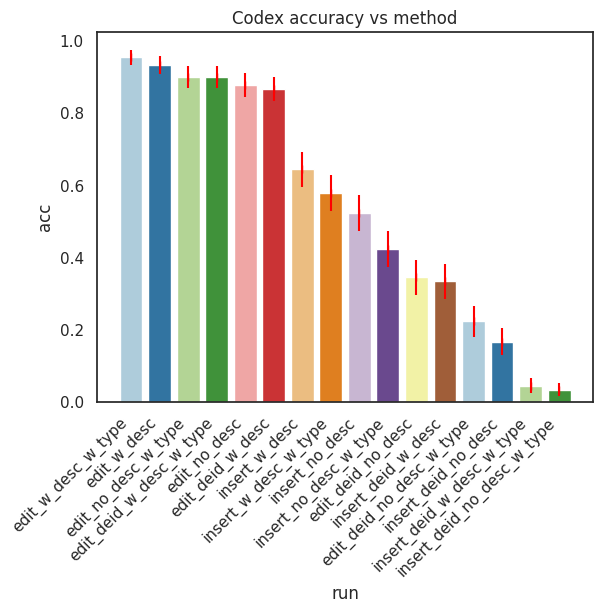

In [15]:
palette = sns.color_palette("Paired")
accs_disp = accuracies.sort_values('acc',ascending=False)
sns.barplot(y=accs_disp['acc'],x=accs_disp.index,palette=palette).set(title='Codex accuracy vs method')
plt.errorbar(x=accs_disp.index,y=accs_disp['acc'],yerr=accs_disp.ci_95_size,fmt="|",color='r')
plt.xticks(rotation=45,ha='right')
print()

solid bar has feature insert = True
solid bar has feature type = True
solid bar has feature desc = True
solid bar has feature funcnames = True


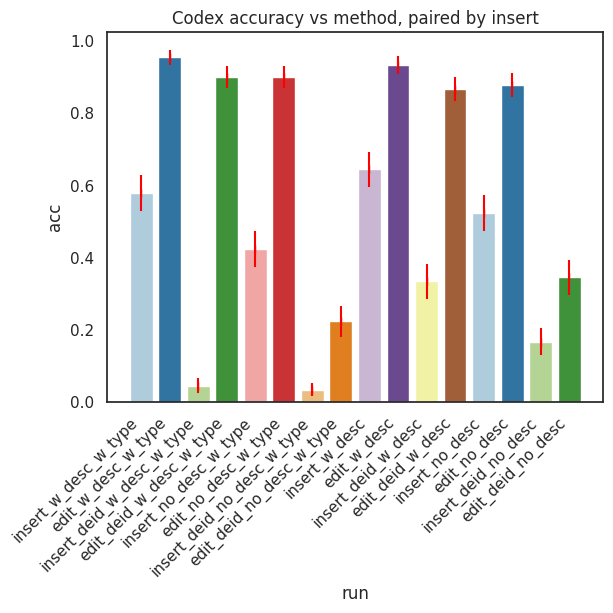

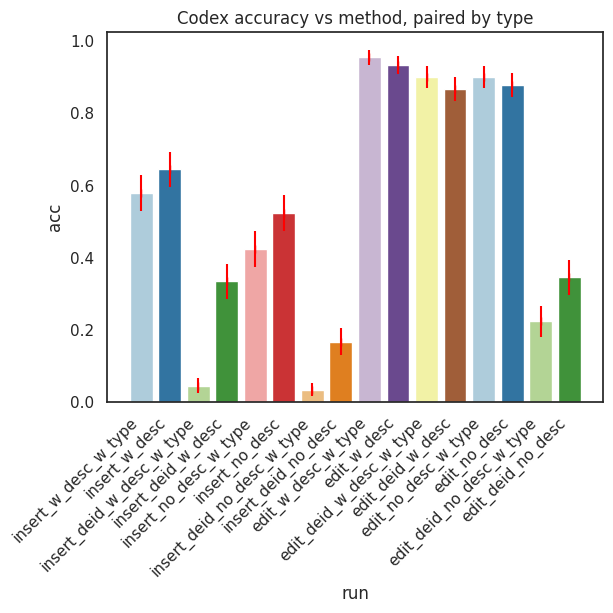

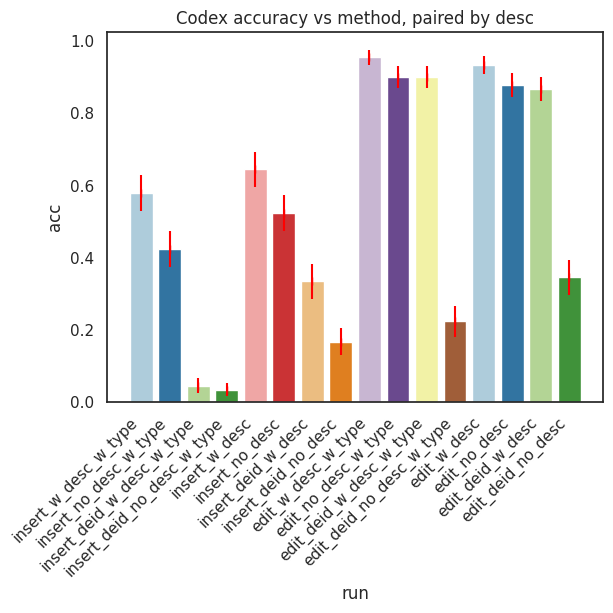

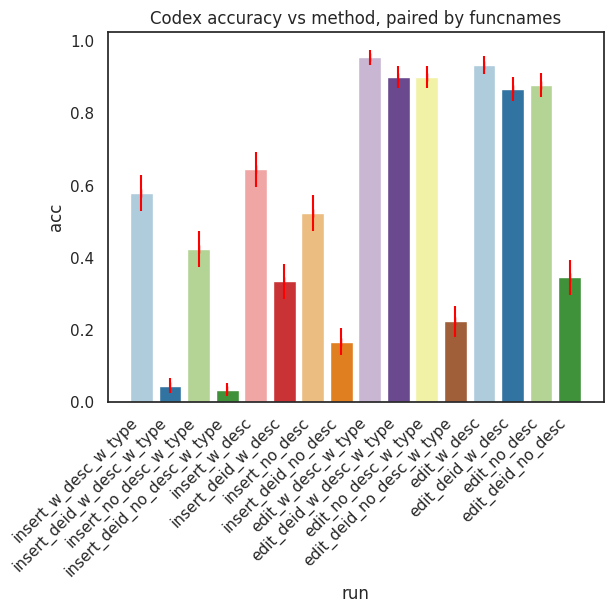

In [16]:
# break this out into some more targeted plots
palette = sns.color_palette("Paired")
# start by doing that ^^ but by pairing each factor 
featcols = ['insert','type','desc','funcnames',]
for i,col in enumerate(featcols): 
    # sort by everything else first, then finally pair up the elt of choice 
    feats = featcols[:i] +  featcols[i+1:] + [col]
    accs_disp = accuracies.sort_values(feats,ascending=False)
    # 
    print(f'solid bar has feature {col} = True')
    plt.figure()
    sns.barplot(y=accs_disp['acc'],x=accs_disp.index,palette=palette).set(title=f'Codex accuracy vs method, paired by {col}')
    plt.errorbar(x=accs_disp.index,y=accs_disp['acc'],yerr=accs_disp.ci_95_size,fmt="|",color='r')
    plt.xticks(rotation=45,ha='right')

## Look at varying a single parameter at a time: 

It may be difficult to see the effects of each change so we will begin by varying each parameter one at a time 

To do this we start from a base parameter set: 
```python 
{'insert':True,'type':False,'desc':False,'funcnames':False} 
```
and then modify each parameter one at a time, by setting the corresponding value to `True`

,acc,std,failures,estimated_std,ci_95_size,ci_95,desc,funcnames,type,insert
base,0.344444,0.475187,0.0,0.225802,0.047851,"(0.2965932321160945, 0.3922956567727944)",False,False,False,False
insert,0.166667,0.372678,0.0,0.138889,0.037529,"(0.12913806750141846, 0.20419526583191486)",False,False,False,True
type,0.222222,0.41574,0.0,0.17284,0.041865,"(0.18035731719104456, 0.2640871272533999)",False,False,True,False
desc,0.866667,0.339935,0.0,0.115556,0.034231,"(0.8324353174613771, 0.9008980158719563)",True,False,False,False
funcnames,0.877778,0.327542,0.0,0.107284,0.032983,"(0.8447943353139421, 0.9107612202416134)",False,True,False,False


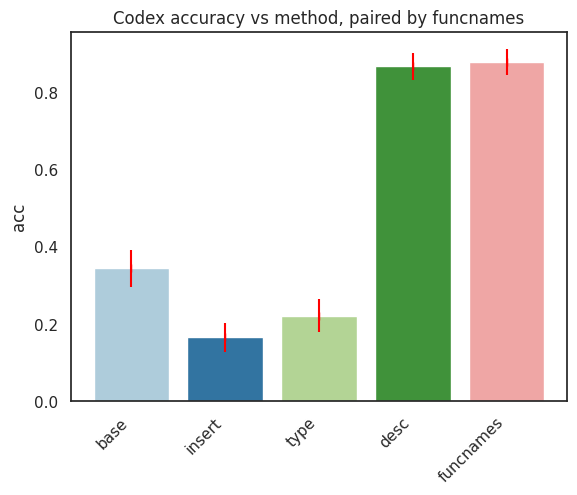

In [17]:
# now use a 'standard' feature set, and look at deviations from it: 
standard_params = {'insert':False,'type':False,'desc':False,'funcnames':False} 
exs = {'base':standard_params}
get_exp = lambda params,df: df[df.apply( lambda y: all(y[param] == val for param,val in params.items() ),axis=1)]
for col in featcols: 
    exs[col] = {param:(val if param != col else not val) for param,val in standard_params.items()}
dispdf = {}
for tag,ex in exs.items(): 
    row = get_exp(ex,accuracies).iloc[0]
    dispdf[tag] = row
dispdf = pd.DataFrame(dispdf).T
# diaplay 

sns.barplot(y=dispdf['acc'],x=dispdf.index,palette=palette).set(title=f'Codex accuracy vs method, paired by {col}')
plt.errorbar(x=dispdf.index,y=dispdf['acc'],yerr=dispdf.ci_95_size,fmt="|",color='r')
plt.xticks(rotation=45,ha='right')
dispdf

### Break out plots for insert mode

Because it looks like the magnitude of the results is slightly different for `insert` and `edit` modes, 
we will treat these seperately and break them into their own plots 

For this we start with the parameter set: 
```python
{'type':False,'desc':False,'funcnames':False}
``` 
 and modify each of the parameters one at a time, and accounting for the insert / edit mode accordingly 

,acc,std,failures,estimated_std,ci_95_size,ci_95,desc,funcnames,type,insert
base,0.166667,0.372678,0.0,0.138889,0.037529,"(0.12913806750141846, 0.20419526583191486)",False,False,False,True
insert,0.166667,0.372678,0.0,0.138889,0.037529,"(0.12913806750141846, 0.20419526583191486)",False,False,False,True
type,0.033333,0.179505,0.0,0.032222,0.018076,"(0.015257166283016464, 0.051409500383650206)",False,False,True,True
desc,0.333333,0.471405,0.0,0.222222,0.04747,"(0.2858629930302621, 0.38080367363640455)",True,False,False,True
funcnames,0.522222,0.499506,25.0,0.249506,0.0503,"(0.4719220757989924, 0.5725223686454521)",False,True,False,True


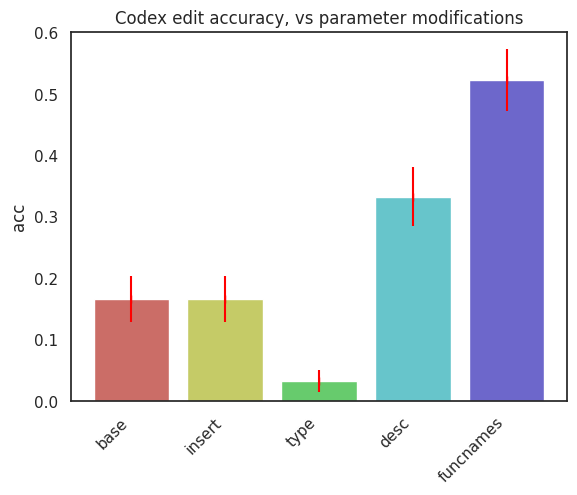

In [21]:
# now use a 'standard' feature set, and look at deviations from it: 
standard_params = {'type':False,'desc':False,'funcnames':False} 
exs = {'base':standard_params,}
get_exp = lambda params,df: df[df.apply( lambda y: all(y[param] == val for param,val in params.items() ),axis=1)]
for col in featcols: 
    exs[col] = {param:(val if param != col else not val) for param,val in standard_params.items()}
dispdf = {}
for tag,ex in exs.items(): 
    ex.update({'insert':True})
    row = get_exp(ex,accuracies).iloc[0]
    dispdf[tag] = row
dispdf = pd.DataFrame(dispdf).T
# diaplay 
palette = sns.color_palette("hls", len(exs)+1)
sns.barplot(y=dispdf['acc'],x=dispdf.index,palette=palette).set(title=f'Codex edit accuracy, vs parameter modifications')
plt.errorbar(x=dispdf.index,y=dispdf['acc'],yerr=dispdf.ci_95_size,fmt="|",color='r')
plt.xticks(rotation=45,ha='right')
dispdf

### Now do the same for edit mode

,acc,std,failures,estimated_std,ci_95_size,ci_95,desc,funcnames,type,insert
base,0.344444,0.475187,0.0,0.225802,0.047851,"(0.2965932321160945, 0.3922956567727944)",False,False,False,False
insert,0.344444,0.475187,0.0,0.225802,0.047851,"(0.2965932321160945, 0.3922956567727944)",False,False,False,False
type,0.222222,0.41574,0.0,0.17284,0.041865,"(0.18035731719104456, 0.2640871272533999)",False,False,True,False
desc,0.866667,0.339935,0.0,0.115556,0.034231,"(0.8324353174613771, 0.9008980158719563)",True,False,False,False
funcnames,0.877778,0.327542,0.0,0.107284,0.032983,"(0.8447943353139421, 0.9107612202416134)",False,True,False,False


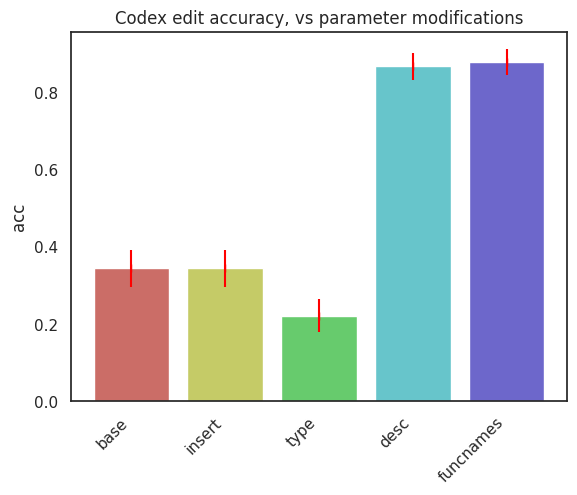

In [12]:
exs = {'base':standard_params,}
get_exp = lambda params,df: df[df.apply( lambda y: all(y[param] == val for param,val in params.items() ),axis=1)]
for col in featcols: 
    exs[col] = {param:(val if param != col else not val) for param,val in standard_params.items()}
dispdf = {}
for tag,ex in exs.items(): 
    ex.update({'insert':False})
    row = get_exp(ex,accuracies).iloc[0]
    dispdf[tag] = row
dispdf = pd.DataFrame(dispdf).T
# diaplay 
palette = sns.color_palette("hls", len(exs)+1)
sns.barplot(y=dispdf['acc'],x=dispdf.index,palette=palette).set(title=f'Codex edit accuracy, vs parameter modifications')
plt.errorbar(x=dispdf.index,y=dispdf['acc'],yerr=dispdf.ci_95_size,fmt="|",color='r')
plt.xticks(rotation=45,ha='right')
dispdf

funcnames        False               True           
type             False     True      False     True 
insert desc                                         
False  False  0.344444  0.222222  0.877778  0.900000
       True   0.866667  0.900000  0.933333  0.955556
True   False  0.166667  0.033333  0.522222  0.422222
       True   0.333333  0.044444  0.644444  0.577778

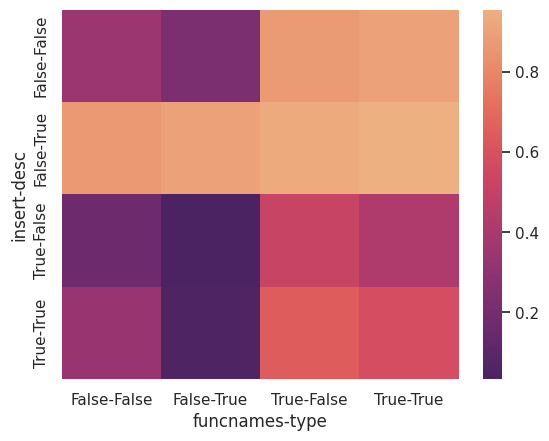

In [34]:
# make a heatmap, to try and visualize rows / cols 
heatmap_df = accuracies.pivot(index = ['insert','desc'], columns = ['funcnames', 'type'],values='acc')
heatmap_df = heatmap_df.sort_index(axis=1)
sns.heatmap(heatmap_df,cmap=sns.color_palette("flare_r", as_cmap=True))
heatmap_df

# look specifically at the effects of adding types: 

,acc,std,failures,estimated_std,ci_95_size,ci_95,desc,funcnames,type,insert
desc,0.333333,0.471405,0.0,0.222222,0.04747,"(0.2858629930302621, 0.38080367363640455)",True,False,False,True
desc+type,0.644444,0.478681,0.0,0.229136,0.048203,"(0.5962413323102662, 0.6926475565786228)",True,True,False,True
funcnames,0.522222,0.499506,25.0,0.249506,0.0503,"(0.4719220757989924, 0.5725223686454521)",False,True,False,True
funcnames+type,0.644444,0.478681,0.0,0.229136,0.048203,"(0.5962413323102662, 0.6926475565786228)",True,True,False,True
both,0.644444,0.478681,0.0,0.229136,0.048203,"(0.5962413323102662, 0.6926475565786228)",True,True,False,True
both+type,0.577778,0.493914,0.0,0.243951,0.049737,"(0.5280407804821414, 0.627514775073414)",True,True,True,True
base,0.166667,0.372678,0.0,0.138889,0.037529,"(0.12913806750141846, 0.20419526583191486)",False,False,False,True
base+type,0.033333,0.179505,0.0,0.032222,0.018076,"(0.015257166283016464, 0.051409500383650206)",False,False,True,True


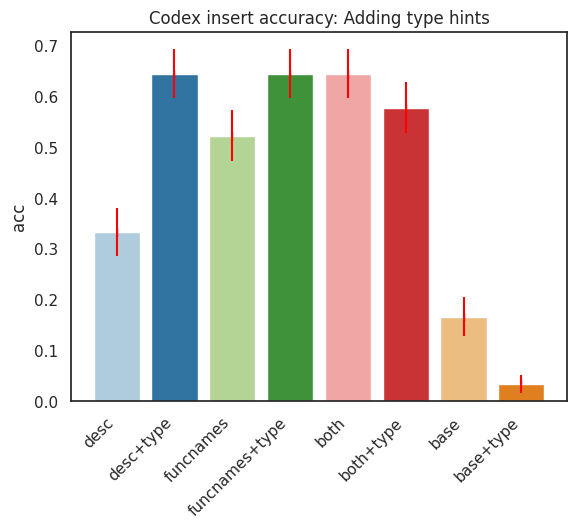

In [40]:
# now use a 'standard' feature set, and look at deviations from it: 
standard_params = {'desc':False,'funcnames':False} 
# lambda function to get 
exs = {}
for col in standard_params.keys(): 
    exs[col] = {param:(val if param != col else not val) for param,val in standard_params.items()}
    exs[col +'+type'] = {param:(val if param in ['col','type'] else not val) for param,val in standard_params.items()}
exs['both'] = {'insert':True,'type':False,'desc':True,'funcnames':True}
exs['both+type'] = {'insert':True,'type':True,'desc':True,'funcnames':True}
exs['base'] = standard_params
exs['base+type'] = {'insert':True,'type':True,'desc':False,'funcnames':False}


dispdf = {}
for tag,ex in exs.items(): 
    ex.update({'insert':True})
    row = get_exp(ex,accuracies).iloc[0]
    dispdf[tag] = row
dispdf = pd.DataFrame(dispdf).T
# diaplay 
palette = sns.color_palette("Paired")
sns.barplot(y=dispdf['acc'],x=dispdf.index,palette=palette).set(title=f'Codex insert accuracy: Adding type hints')
plt.errorbar(x=dispdf.index,y=dispdf['acc'],yerr=dispdf.ci_95_size,fmt="|",color='r')
plt.xticks(rotation=45,ha='right')
dispdf


,acc,std,failures,estimated_std,ci_95_size,ci_95,desc,funcnames,type,insert
desc,0.866667,0.339935,0.0,0.115556,0.034231,"(0.8324353174613771, 0.9008980158719563)",True,False,False,False
desc+type,0.933333,0.249444,0.0,0.062222,0.025119,"(0.9082143903146268, 0.9584522763520399)",True,True,False,False
funcnames,0.877778,0.327542,0.0,0.107284,0.032983,"(0.8447943353139421, 0.9107612202416134)",False,True,False,False
funcnames+type,0.933333,0.249444,0.0,0.062222,0.025119,"(0.9082143903146268, 0.9584522763520399)",True,True,False,False
both,0.933333,0.249444,0.0,0.062222,0.025119,"(0.9082143903146268, 0.9584522763520399)",True,True,False,False
both+type,0.955556,0.20608,0.0,0.042469,0.020752,"(0.9348032996712166, 0.9763078114398946)",True,True,True,False
base,0.344444,0.475187,0.0,0.225802,0.047851,"(0.2965932321160945, 0.3922956567727944)",False,False,False,False
base+type,0.222222,0.41574,0.0,0.17284,0.041865,"(0.18035731719104456, 0.2640871272533999)",False,False,True,False


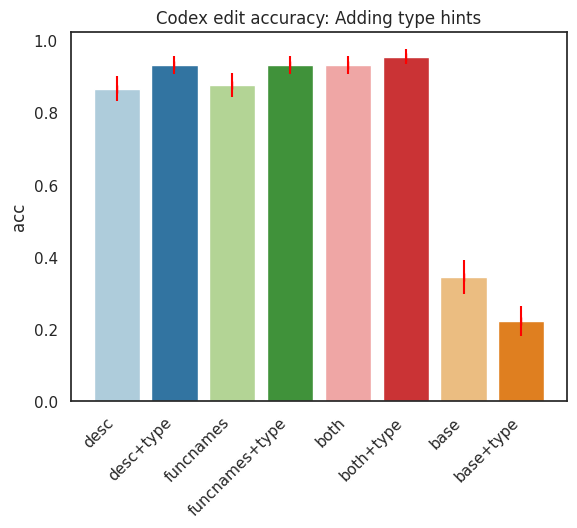

In [41]:
# # now use a 'standard' feature set, and look at deviations from it: 
standard_params = {'desc':False,'funcnames':False} 
# lambda function to get 
exs = {}
for col in standard_params.keys(): 
    exs[col] = {param:(val if param != col else not val) for param,val in standard_params.items()}
    exs[col +'+type'] = {param:(val if param in ['col','type'] else not val) for param,val in standard_params.items()}
exs['both'] = {'insert':False,'type':False,'desc':True,'funcnames':True}
exs['both+type'] = {'insert':False,'type':True,'desc':True,'funcnames':True}
exs['base'] = standard_params
exs['base+type'] = {'insert':False,'type':True,'desc':False,'funcnames':False}

dispdf = {}
for tag,ex in exs.items(): 
    ex.update({'insert':False})
    row = get_exp(ex,accuracies).iloc[0]
    dispdf[tag] = row
dispdf = pd.DataFrame(dispdf).T
# diaplay 
palette = sns.color_palette("Paired")
sns.barplot(y=dispdf['acc'],x=dispdf.index,palette=palette).set(title=f'Codex edit accuracy: Adding type hints')
plt.errorbar(x=dispdf.index,y=dispdf['acc'],yerr=dispdf.ci_95_size,fmt="|",color='r')
plt.xticks(rotation=45,ha='right')
dispdf


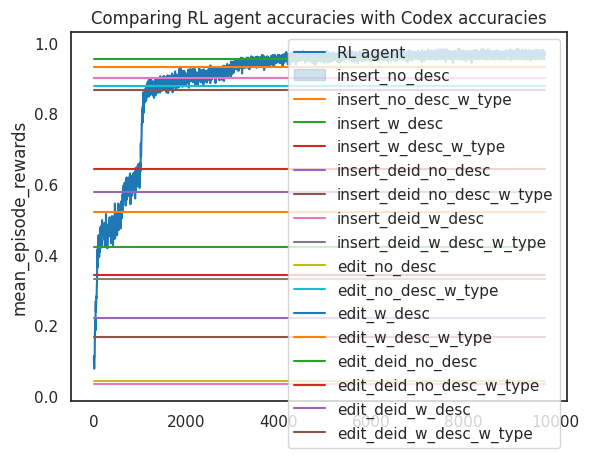

In [14]:
# now pull in data from one of eric's training runs
with open('data/graph_data.json','r') as file: 
    run_data = json.load(file)
    run_data = pd.DataFrame(run_data['values'])
num_episodes = len(run_data)


# then graph that on an axis with our stuff 
sns.lineplot(y=run_data['mean_episode_rewards'],x=run_data.index)
for val in accuracies['acc']:
    plt.plot([0,num_episodes],[val,val])
plt.title('Comparing RL agent accuracies with Codex accuracies')
plt.legend(['RL agent'] + list(accuracies.index))


In [115]:
? sns.heatmap

Signature:
 sns.heatmap(
    data,
    *,
    vmin=None,
    vmax=None,
    cmap=None,
    center=None,
    robust=False,
    annot=None,
    fmt='.2g',
    annot_kws=None,
    linewidths=0,
    linecolor='white',
    cbar=True,
    cbar_kws=None,
    cbar_ax=None,
    square=False,
    xticklabels='auto',
    yticklabels='auto',
    mask=None,
    ax=None,
    **kwargs,
)
Docstring:
Plot rectangular data as a color-encoded matrix.

This is an Axes-level function and will draw the heatmap into the
currently-active Axes if none is provided to the ``ax`` argument.  Part of
this Axes space will be taken and used to plot a colormap, unless ``cbar``
is False or a separate Axes is provided to ``cbar_ax``.

Parameters
----------
data : rectangular dataset
    2D dataset that can be coerced into an ndarray. If a Pandas DataFrame
    is provided, the index/column information will be used to label the
    columns and rows.
vmin, vmax : floats, optional
    Values to anchor the colormap, otherwis

ls: cannot access '../../environment/data/': No such file or directory
